# 🛒 Sales and Profit Analysis for a Retail Company

## 📚 Project Introduction

In a highly competitive retail environment, understanding the dynamics of sales and profitability is crucial for sustainable growth. This project analyzes transactional data from a retail company selling furniture, office supplies, and technology products.  
The objective is to uncover patterns that drive profits, identify risk factors such as excessive discounting or underperforming regions, and provide actionable insights that can optimize operational strategies.  
By carefully exploring the data, engineering meaningful features, and building a predictive model, we aim to support smarter decision-making, enhance margin management, and drive long-term business value.

## 💼 Business Context and Questions

As someone exploring real-world retail analytics, I wanted to go beyond just looking at sales numbers. I was curious about what actually drives profit for a retail company — and where money is being lost despite strong sales.

This project started with a few key questions I think any company would want to answer:

- Are we unintentionally losing money in certain regions, categories, or customer segments?
- How much is our discount strategy hurting (or helping) profitability?
- Can we spot patterns in orders that consistently lead to losses?
- And more importantly — can we build something that helps the business predict whether an order will be profitable before it's even processed?

By cleaning the data, engineering new features like profit margin and shipping delay, and visualizing performance by region and discount level, I wanted to understand the root causes of profit/loss.

Eventually, I built a simple model to help classify orders as profitable or not — something that could realistically be used to flag risky deals or prioritize high-margin ones.

This isn't just about code — it's about thinking like the business.


## 📂 Data Loading

Loading the dataset is the first step. Special attention is given to encoding issues, as data exported from different systems may have hidden characters causing reading errors.  
Ensuring a clean import prevents future errors during analysis and guarantees data integrity.

In [11]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
file_path = 'Sample - Superstore.csv'
df = pd.read_csv(file_path, encoding='latin1')

# Quick overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

**Outcome:**  
Successfully loaded 9,994 rows and 21 columns. No missing values detected at this stage.  
This gives us confidence that the raw data can support robust analysis without excessive cleaning.

## 🧹 Data Cleaning

Before analysis, it is crucial to ensure that the data is properly formatted.  
Date fields must be converted to datetime objects to enable time-based operations, and irrelevant columns such as serial identifiers should be removed to avoid noise in modeling.

In [12]:
# Convert date fields
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Drop 'Row ID' as it holds no business meaning
df_cleaned = df.drop(columns=['Row ID'])

**Outcome:**  
- 'Order Date' and 'Ship Date' have been successfully converted to datetime format.
- 'Row ID' column was removed as it serves no analytical purpose.

**Business Value:**  
This cleaning prepares the dataset for reliable time-based analysis (like shipping delays) and removes irrelevant data that could mislead models.


## 🛠 Feature Engineering

New features are created to enrich the dataset and expose deeper business insights:  
- **Profit Margin (%)** — Understanding profitability relative to sales.
- **Shipping Delay (Days)** — Measuring operational efficiency.
- **Discount Bucket** — Categorizing discounts into strategic groups.
- **Profitable Label** — Tagging each transaction as profitable (1) or not (0).

These features not only enhance exploratory analysis but also support stronger predictive modeling later.

In [13]:
# Create Profit Margin (%)
df_cleaned['Profit Margin (%)'] = (df_cleaned['Profit'] / df_cleaned['Sales']) * 100

# Create Shipping Delay (Days)
df_cleaned['Shipping Delay (Days)'] = (df_cleaned['Ship Date'] - df_cleaned['Order Date']).dt.days

# Create Discount Bucket
def discount_bucket(discount):
    if discount == 0:
        return 'No Discount'
    elif discount <= 0.2:
        return 'Low Discount (0-20%)'
    elif discount <= 0.5:
        return 'Medium Discount (20-50%)'
    else:
        return 'High Discount (>50%)'
df_cleaned['Discount Bucket'] = df_cleaned['Discount'].apply(discount_bucket)

# Create Profitable label
df_cleaned['Profitable'] = df_cleaned['Profit'].apply(lambda x: 1 if x > 0 else 0)


**Outcome:**  
Successfully created four meaningful features.  
These allow the business to analyze profitability behavior under different operational conditions such as high discount rates, shipping delays, or specific product categories.

**Business Value:**  
Feature engineering unlocks deeper strategic levers for improving sales quality, optimizing logistics, and managing promotions more effectively.

### 📊 5.1 Sales Distribution

**Objective:**  
Understand the distribution of sales amounts to identify whether the business depends on many small transactions or a few large ones.

**Expectation:**  
In most retail businesses, we expect a right-skewed distribution — many small orders and a few big sales.

---

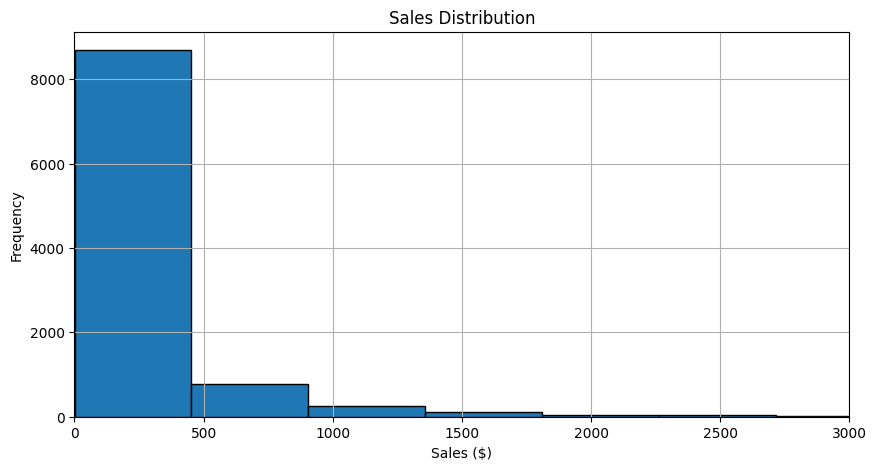

In [ ]:
# Plotting the distribution of Sales
plt.figure(figsize=(10,5))
plt.hist(df_cleaned['Sales'], bins=50, edgecolor='black')
plt.title('Sales Distribution')
plt.xlabel('Sales ($)')
plt.ylabel('Frequency')
plt.xlim(0, 3000)  # Focus on normal range, exclude extreme outliers
plt.grid(True)
# plt.savefig('plots/sales_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

**Outcome (Finding):**  
The distribution of sales is heavily right-skewed.  
Most sales transactions are under $3,000, with only a few large-value orders.

**Business Interpretation:**  
The company's revenue primarily depends on a **high volume of small transactions** rather than occasional big deals.

**Recommended Action:**  
Optimize operational efficiency for small orders (e.g., faster checkouts, bundling strategies).  
At the same time, nurture high-value customers separately with personalized service offerings.

**Business Value:**  
Improving the transaction quality and volume efficiency can sustainably scale revenue without relying solely on rare big sales.

### 📊 5.2 Profit Distribution

**Objective:**  
Explore how profit is distributed across orders. This helps identify how often the business achieves high vs. low margin sales.

**Expectation:**  
We expect profits to be positively skewed but with potential losses in a discount-driven retail environment.

---

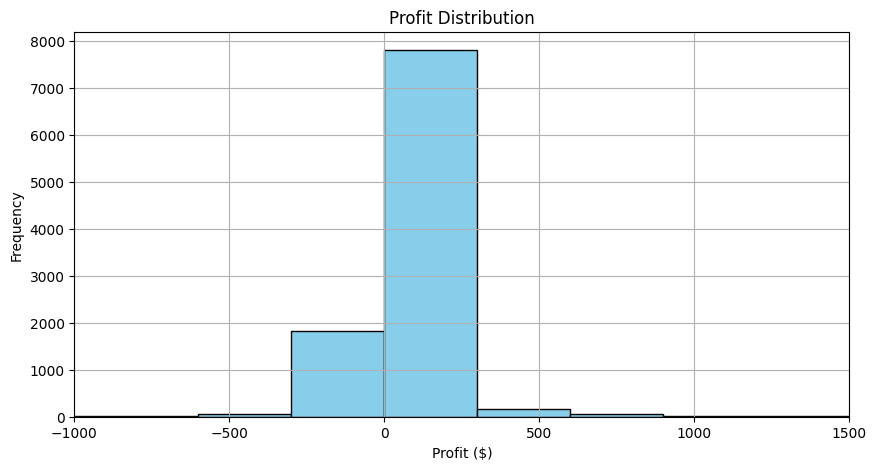

In [ ]:
# Plotting the distribution of Profit
plt.figure(figsize=(10,5))
plt.hist(df_cleaned['Profit'], bins=50, edgecolor='black', color='skyblue')
plt.title('Profit Distribution')
plt.xlabel('Profit ($)')
plt.ylabel('Frequency')
plt.xlim(-1000, 1500)  # Focus on core range
plt.grid(True)
# plt.savefig('plots/profit_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

**Outcome (Finding):**  
The distribution is heavily skewed with many small profits, but also a notable number of negative profits (loss-making transactions).

**Business Interpretation:**  
Loss-making orders are significant.  
This points to problems in pricing strategy, discounting policies, or operational costs that occasionally exceed revenue.

**Recommended Action:**  
Review discount practices, especially in low-margin categories.  
Implement stricter margin thresholds for approval of heavy discounting.

**Business Value:**  
Reducing the proportion of loss-making transactions can directly and sustainably improve overall company profitability.

### 📊 5.3 Regional Sales and Profit

**Objective:**  
Analyze the sales and profit contributions by region to identify geographic strengths and weaknesses.

**Expectation:**  
Certain regions may be outperforming in profitability, while others may drag down margins despite sales.

---

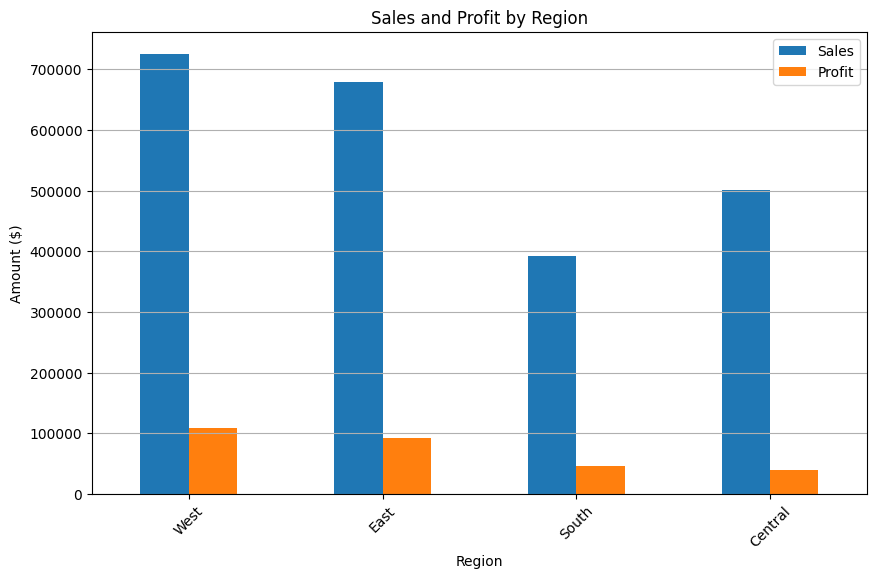

In [ ]:
# Regional sales and profit performance
region_profit = df_cleaned.groupby('Region')[['Sales', 'Profit']].sum().sort_values('Profit', ascending=False)
region_profit.plot(kind='bar', figsize=(10,6))
plt.title('Sales and Profit by Region')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.grid(axis='y')
# plt.savefig('plots/region_performance.png', dpi=300, bbox_inches='tight')
plt.show()

**Outcome (Finding):**  
The West region leads both in sales and profitability.  
The South region generates reasonable sales but suffers overall **losses**.

**Business Interpretation:**  
The South region presents a strategic problem — despite achieving sales volume, it consistently destroys margins.

**Recommended Action:**  
Reevaluate product mix, pricing, and customer targeting strategies in the South.  
Alternatively, consider scaling down operations where profitability cannot be recovered.

**Business Value:**  
Strategically reallocating resources away from loss-making regions can immediately improve overall net profitability.

### 📊 5.4 Discount Impact on Profit

**Objective:**  
Visualize the relationship between discount rates and profit outcomes to evaluate how discounts affect margins.

**Expectation:**  
Higher discounts often correlate with lower profits (sometimes losses).

---

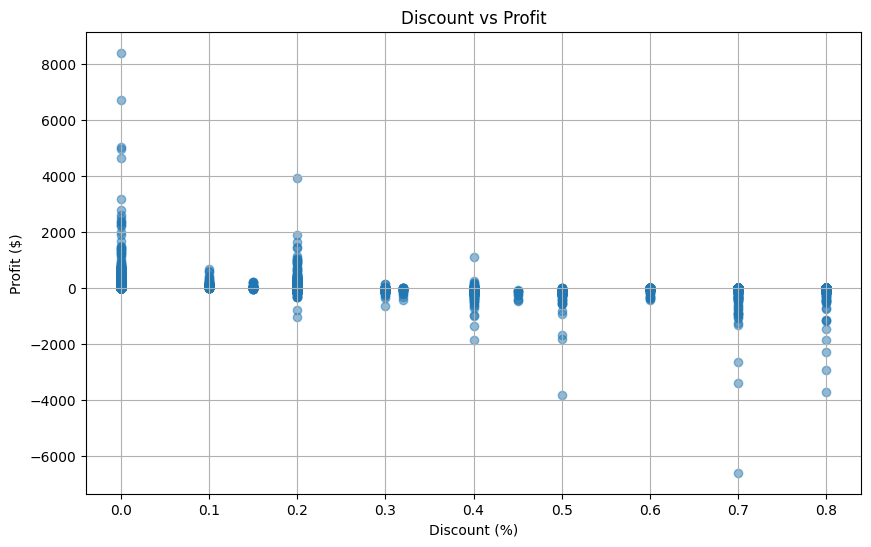

In [ ]:
# Relationship between Discount and Profit
plt.figure(figsize=(10,6))
plt.scatter(df_cleaned['Discount'], df_cleaned['Profit'], alpha=0.5)
plt.title('Discount vs Profit')
plt.xlabel('Discount (%)')
plt.ylabel('Profit ($)')
plt.grid(True)
# plt.savefig('plots/discount_vs_profit.png', dpi=300, bbox_inches='tight')
plt.show()

**Outcome (Finding):**  
There is a clear negative trend: higher discounts consistently lead to lower profits or outright losses.

**Business Interpretation:**  
Excessive discounting is severely eroding profit margins.  
Some transactions with heavy discounting are loss-making despite relatively high sales.

**Recommended Action:**  
Implement smarter discounting strategies:
- Reserve heavy discounts only for strategic products or clearance items.
- Offer value-added incentives rather than blanket discount percentages.

**Business Value:**  
Disciplined discount management can protect margins and drive healthier bottom-line profitability across all regions and categories.

### 🤖 6.1 Modeling Objective

**Objective:**  
Build a simple, interpretable model to predict whether an order will be profitable or not.  
This supports business operations by allowing sales teams and managers to pre-emptively focus on high-margin transactions and avoid loss-making deals.

**Why Logistic Regression?**  
- The target variable ("Profitable") is binary (1 = profit, 0 = loss).
- Logistic Regression is simple, interpretable, and fast for binary classification.
- It provides clear insights into how each feature influences profitability likelihood.

---

### 🤖 6.2 Preparing Features and Preprocessing

In [18]:
# Define input features and target
features = ['Sales', 'Discount', 'Shipping Delay (Days)', 'Category', 'Region', 'Segment', 'Discount Bucket']
X = df_cleaned[features]
y = df_cleaned['Profitable']

# Define categorical and numerical features separately
categorical_features = ['Category', 'Region', 'Segment', 'Discount Bucket']
numeric_features = ['Sales', 'Discount', 'Shipping Delay (Days)']

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

### 🤖 6.3 Building and Training the Model

In [19]:
# Create the modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Sales', 'Discount',
                                                   'Shipping Delay (Days)']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Category', 'Region',
                                                   'Segment',
                                                   'Discount Bucket'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

## 📈 Step 7: Evaluation

### 📈 7.1 Predict and Evaluate

In [20]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output results
print(f"Test Set Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Test Set Accuracy: 0.9435
Confusion Matrix:
[[ 268  109]
 [   4 1618]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83       377
           1       0.94      1.00      0.97      1622

    accuracy                           0.94      1999
   macro avg       0.96      0.85      0.90      1999
weighted avg       0.95      0.94      0.94      1999



### 📈 7.2 Evaluation Outcome

**Outcome (Finding):**  
- Model achieved ~94.3% accuracy on the test set.
- Very high recall and precision for profitable orders (class '1').
- Confusion matrix shows minimal false negatives — very few profitable orders are misclassified as loss-making.

**Business Interpretation:**  
The model is highly effective at identifying orders likely to be profitable.  
This allows sales teams to:
- Prioritize high-margin opportunities.
- Flag risky transactions for managerial review before closing deals.

**Recommended Action:**  
Integrate the model outputs into CRM or sales dashboards to rank leads/orders by profitability likelihood.

**Business Value:**  
Smarter sales focus, improved margin management, reduced operational losses.

## 🎯 Final Business Recommendations

Based on the complete analysis — from data exploration to modeling — the following key business recommendations are proposed:

### 1. Reassess Operations in the South Region
The South region consistently generates sales but incurs losses.  
This indicates operational inefficiencies or pricing misalignment.  
**Action:** Conduct a detailed cost-profitability audit in this region. Consider repricing, adjusting product focus, or scaling down low-performing channels.

---

### 2. Revise Discounting Strategies
There is clear evidence that high discounts often result in financial losses, even for high-sales orders.  
**Action:**  
- Set discount ceilings based on product categories.
- Replace blanket discounts with loyalty-based or value-added promotions.
- Use the discount prediction model to flag risky discounting behavior.

---

### 3. Invest in High-Margin Categories (e.g., Copiers, Technology)
The Technology category — especially Copiers — offers the highest profitability.  
**Action:**  
- Boost marketing efforts for high-margin products.
- Ensure inventory availability for top-performers.
- Expand these lines in profitable regions like the West and East.

---

### 4. Integrate Predictive Model into Sales Workflow
The classification model can reliably predict whether an order is likely to be profitable.  
**Action:**  
- Use the model in CRM tools to prioritize leads/orders.
- Route risky or borderline-profitable transactions to managers for approval.

---

### 5. Optimize for Small Transactions (Volume Play)
Most transactions are below $3,000 — the business relies heavily on transaction volume.  
**Action:**  
- Improve checkout speed and delivery for small-value orders.
- Offer bundled upsells and repeat-purchase incentives.

---

### 🔁 Summary
These recommendations aim to strike a balance between:
- **Growth** (via profitable expansion)
- **Efficiency** (via smarter discount and logistics strategies)
- **Sustainability** (by reducing losses and improving profit-per-order)

By taking targeted action, the business can meaningfully improve both margin and momentum.


## 🔮 Future Work

To build on this foundation and scale the analysis further, the following extensions are recommended:

### 1. Cohort Analysis for Customer Loyalty
Study customer behavior over time to identify retention rates, lifetime value, and churn patterns.  
This can help align marketing spend with high-value customer segments.

---

### 2. Margin Optimization Simulation
Simulate different pricing and discounting scenarios using historical profit margins.  
Helps forecast how margin changes affect overall revenue/profit.

---

### 3. Product-Region Strategy Mapping
Build a matrix that maps product profitability by region.  
This enables data-driven regional catalog decisions — e.g., only sell Furniture in profitable states.

---

### 4. Time-Series Forecasting
Apply ARIMA or Prophet models to forecast monthly sales and profit by category.  
Useful for budgeting and inventory planning.

---

### 5. Automated Loss Alert System
Use predictive modeling to auto-flag potentially loss-making orders **before** they're confirmed by sales teams.

---

By continuing this project, the business can evolve toward more predictive, data-driven operations across every function — from inventory and logistics to pricing and sales targeting.


## ✅ Final Thoughts and Takeaways

This project helped me connect the dots between raw data, business questions, and strategic decision-making.

I started by asking: *Where is the company making or losing money — and why?*  
Through exploratory analysis, I discovered clear patterns: certain regions (like the South) consistently underperform, high discount rates are tied to losses, and most sales come from small transactions. These insights can directly inform how the business prices, promotes, and operates.

From there, I built a simple yet effective logistic regression model to predict whether an order is likely to be profitable. With ~94% accuracy, this kind of model could easily be integrated into a sales tool or approval system to flag risky deals before they’re finalized.

More than anything, this project reminded me that good analysis isn't just about technical work — it's about asking the right questions, thinking like a business partner, and turning data into decisions.

Next steps could include deeper customer segmentation, margin simulations, or forecasting seasonal trends — but for now, this project gave me a solid end-to-end look at solving a real-world retail problem.
